# Lesson 1 - Own Image dataset



The goal of this assignment is to create my own image dataset and use ResNet to classify the images

**Idea: Classify paintings from: Van Gogh, Picasso, Monet, Dali**

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

## Get images from Google Images: 
https://forums.fast.ai/t/tips-for-building-large-image-datasets/26688
I ran into some errors, especially to install both Chrome and Chromedriver from the command line.
What worked:
1. ``pip install google_images_download``
2. go to: https://chromedriver.storage.googleapis.com/index.html?path=73.0.3683.20/
3. Download chromedriver_linux64.zip , unzip it and add the chromedriver binary file to: /usr/local/bin
4. Install chrome following this thread: https://askubuntu.com/questions/79280/how-to-install-chrome-browser-properly-via-command-line (first or second answer)
5. Finally, run: ``googleimagesdownload -k "monet paintings" -s medium -f jpg  -l 300 -o train/ -i monet  -cd /usr/local/bin/chromedriver``

## Train and validation sets
* Train: 300 images ``path_img/train``
* Validation: 200 images ``path_img/valid``

Code: ``googleimagesdownload -k "monet paintings" -s medium -f jpg  -l 400 -o valid/ -i monet  -cd /usr/local/bin/chromedriver -of 300``

## Looking at the data

In [3]:
path = Path("/home/jupyter/assignments")
path_img = path/'lesson1/art'
path.ls()

[PosixPath('/home/jupyter/assignments/.ipynb_checkpoints'),
 PosixPath('/home/jupyter/assignments/lesson1')]

Some of our images are corrupted, so we found this script that removes them.


In [4]:

def check_images(path_img):   
    broken_images=[]
    for pic_class in os.listdir(path_img):
        for pic in os.listdir(f'{path_img}/{pic_class}'):
            try:
                img = PIL.Image.open(f'{path_img}/{pic_class}/{pic}') 
                img.verify()
            except (IOError, SyntaxError) as e:
                print('Bad file:', f'{path_img}/{pic_class}/{pic}')
                broken_images.append(f'{path_img}/{pic_class}/{pic}')
    return broken_images
# Train
img_to_del = check_images(f'{path_img}/train')
[os.remove(pic) for pic in img_to_del]

# Validation
img_to_del = check_images(f'{path_img}/valid')
[os.remove(pic) for pic in img_to_del]

[]

In [5]:
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(path_img, ds_tfms=tfms, size=224)

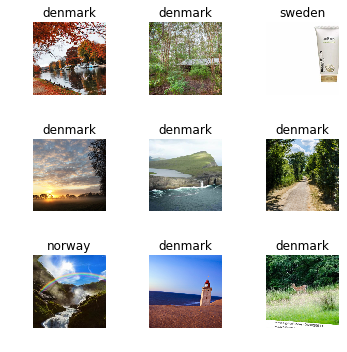

In [58]:
data.show_batch(rows=3, figsize=(5,5))

In [59]:
print(data.classes)

['denmark', 'norway', 'sweden']


In [6]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [7]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate
1,1.263108,1.013291,0.436137
2,1.085108,0.911558,0.358255
3,0.920626,0.890468,0.376947
4,0.846935,0.886944,0.370717


## Results
Let's interpret the results:

* "Categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. "

* Confusion matrix

In [62]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

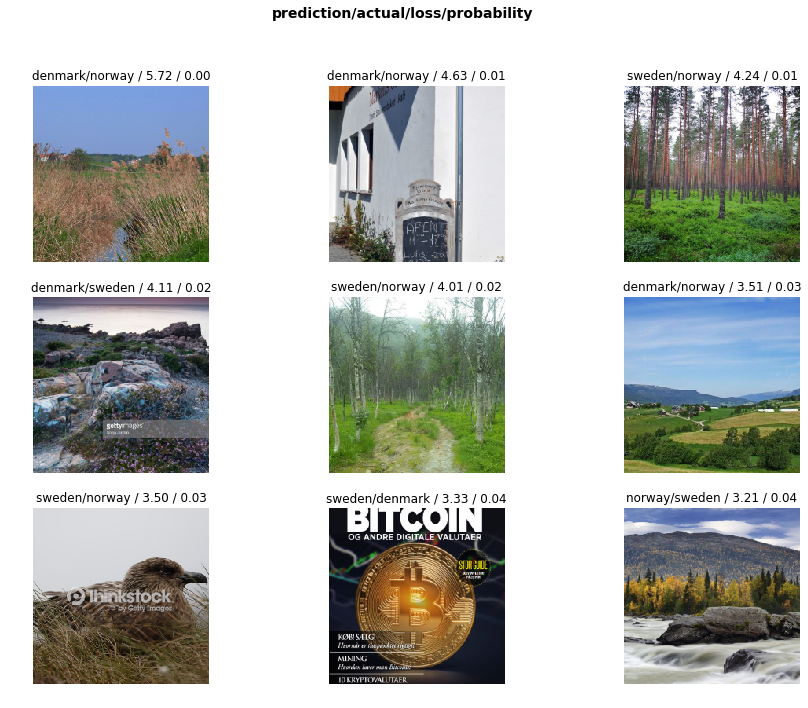

In [63]:
interp.plot_top_losses(9, figsize=(15,11))

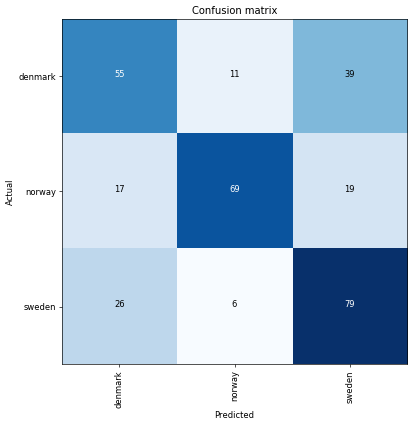

In [64]:
interp.plot_confusion_matrix(figsize=(7,7), dpi=60)

In [65]:
interp.most_confused(min_val=2)

[('denmark', 'sweden', 39),
 ('sweden', 'denmark', 26),
 ('norway', 'sweden', 19),
 ('norway', 'denmark', 17),
 ('denmark', 'norway', 11),
 ('sweden', 'norway', 6)]

## Unfreezing, fine-tuning

In [66]:
learn.unfreeze()

In [67]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate
1,0.863260,0.971808,0.414330


In [68]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


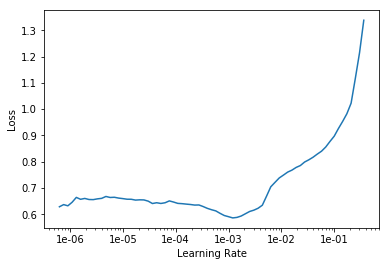

In [69]:
learn.recorder.plot()

In [70]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate
1,0.673683,0.869368,0.392523
2,0.636859,0.853403,0.386293


## Resnet50 and higher resolution
At the moment we have really high loss (error rate). We are going to try and make the images bigger, to have a higher resolution. And then use resnet50, see if we get a higher accuracy. 
ATM we are working with a few images in the training set and the validation. We need one 10 times bigger. But there are no more images

In [8]:
bs = 64

In [9]:
data = ImageDataBunch.from_folder(path_img,ds_tfms=get_transforms(),
                                   size=299, bs=bs//2).normalize(imagenet_stats)

In [10]:
learn = create_cnn(data, models.resnet50, metrics=error_rate)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


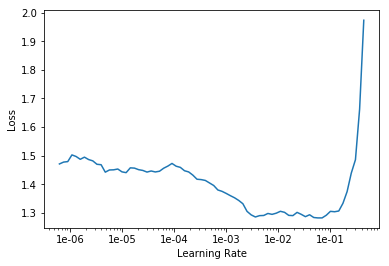

In [11]:
learn.lr_find()
learn.recorder.plot()

In [12]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate
1,1.134373,1.008334,0.417445
2,0.981608,1.001690,0.411215
3,0.862349,0.950904,0.386293
4,0.759887,0.900586,0.370717
5,0.663624,0.852633,0.327103
6,0.581597,0.843995,0.311526
7,0.527258,0.872339,0.308411
8,0.472315,0.867380,0.314642


In [13]:
learn.save('stage-1-50')

In [15]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))


epoch,train_loss,valid_loss,error_rate
1,0.440624,0.867192,0.305296
2,0.433397,0.869481,0.302181
3,0.411830,0.864712,0.289720


## Summary
The goal was to classify images from Swedish, Norwegian, and Danish nature.
It looks like our lowest error rate is 0.28. Which is a big improvement from the first approach, but still nowhere near a result such as 90% accuracy.
We believe that is because of the images provided, the dataset is quite small and the landscapes are very similar. 
We would need more images but we can't get more from Google Images atm. 